## Вступление

<i><h4>Описание</h4></i>
Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей,
которые готовы совершить покупку в ближайшее время.

<i><h4>Цель</h4></i>
Предсказать вероятность покупки в течение 90 дней

<i><h4>Задачи</h4></i>
● Изучить данные <br>
● Разработать полезные признаки<br>
● Создать модель для классификации пользователей<br>
● Улучшить модель и максимизировать метрику roc_auc<br>
● Выполнить тестирование<br>

<i><h4>Данные</h4></i>
apparel-purchases – история покупок
apparel-messages – история рекламных рассылок
apparel-target_binary – совершит ли клиент покупку в течение следующих 90 дней

In [1]:
# установка библиотек
!python3 -m pip install seaborn -q
!python3 -m pip install phik -q

In [2]:
# импорт библиотек
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import warnings
warnings.filterwarnings("ignore")
import ast


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

# загружаем модели
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split,RandomizedSearchCV, GridSearchCV
from sklearn.compose import ColumnTransformer

# загружаем классы для подготовки данных
from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler
)

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score

In [3]:
# константы
TEST_SIZE = 0.2
RANDOM_STATE = 42

In [4]:
# Функция создает для списка столбцов два графика - гистограмму и ящик с усами.
def todoplot(df):
    for i in col_1:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        ax1.hist(df[i], bins=10);
        ax1.set_title(i)
        ax1.set_xlabel('Значения')
        ax1.set_ylabel('Частота')
        ax2.boxplot(df[i]);
        ax2.set_title(i)
        plt.show()

## Подготовка данных

In [5]:
# Загружаем файлы

pth1 = '/Users/georgekhokhlov/Cursor_project/YA_proj/Masterskaya_2/sources/apparel-messages.csv'
pth2 = '/Users/georgekhokhlov/Cursor_project/YA_proj/Masterskaya_2/sources/apparel-purchases.csv'
pth3 = '/Users/georgekhokhlov/Cursor_project/YA_proj/Masterskaya_2/sources/apparel-target_binary.csv'
pth4 = '/Users/georgekhokhlov/Cursor_project/YA_proj/Masterskaya_2/sources/full_campaign_daily_event_channel.csv'
pth5 = '/Users/georgekhokhlov/Cursor_project/YA_proj/Masterskaya_2/sources/full_campaign_daily_event.csv'


if os.path.exists(pth2):
    purchases = pd.read_csv(pth2)
    print(f'Файл apparel_purchases.csv успешно загружен')
else:
    print('Возникла ошибка при чтении таблиц')

if os.path.exists(pth1):
    messages = pd.read_csv(pth1)
    print(f'Файл apparel_messages.csv успешно загружен')
else:
    print('Возникла ошибка при чтении таблиц')

if os.path.exists(pth3):
    target = pd.read_csv(pth3)
    print(f'Файл target.csv успешно загружен')
else:
    print('Возникла ошибка при чтении таблиц')

if os.path.exists(pth4):
    daily_event_channel = pd.read_csv(pth4)
    print(f'Файл daily_event_channel.csv успешно загружен')
else:
    print('Возникла ошибка при чтении таблиц')

if os.path.exists(pth5):
    daily_event = pd.read_csv(pth5)
    print(f'Файл daily_event.csv успешно загружен')
else:
    print('Возникла ошибка при чтении таблиц')

Файл apparel_purchases.csv успешно загружен
Файл apparel_messages.csv успешно загружен
Файл target.csv успешно загружен
Файл daily_event_channel.csv успешно загружен
Файл daily_event.csv успешно загружен


In [6]:
purchases.info()
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


In [7]:
target.info()
daily_event_channel.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   date                             131072 non-null  object
 1   bulk_campaign_id                 131072 non-null  int64 
 2   count_click_email                131072 non-null  int64 
 3   count_click_mobile_push          131072 non-null  int64 
 4   count_open_email                 131072 non-null  int64 
 5   count_open_mobile_push           131072 non-null  int64 
 6   count_purchase_email             131072 non-null  int64 
 7   count_purchase_mobile_push

In [13]:
daily_event.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 131072 non-null  object
 1   bulk_campaign_id     131072 non-null  int64 
 2   count_click          131072 non-null  int64 
 3   count_complain       131072 non-null  int64 
 4   count_hard_bounce    131072 non-null  int64 
 5   count_open           131072 non-null  int64 
 6   count_purchase       131072 non-null  int64 
 7   count_send           131072 non-null  int64 
 8   count_soft_bounce    131072 non-null  int64 
 9   count_subscribe      131072 non-null  int64 
 10  count_unsubscribe    131072 non-null  int64 
 11  nunique_click        131072 non-null  int64 
 12  nunique_complain     131072 non-null  int64 
 13  nunique_hard_bounce  131072 non-null  int64 
 14  nunique_open         131072 non-null  int64 
 15  nunique_purchase     131072 non-nu

In [8]:
# изменим тип данных в столбце с датой
purchases['date'] = pd.to_datetime(purchases['date'])
messages['date'] = pd.to_datetime(messages['date'])
messages['created_at'] = pd.to_datetime(messages['created_at'])
daily_event_channel['date'] = pd.to_datetime(daily_event_channel['date'])
daily_event['date'] = pd.to_datetime(daily_event['date'])

Таблицы имеют общепринятое отображение и отсутствуют пропуски. В колонеках с датой изменен тип данных для дальнейшей корректной обработке. В рамках ТЗ и на встрече определено не использовать таблицы daily_event_channel и daily_event. Можно перейти к следующему этапу – создание новый признаков и их анализ.

В колонке category_ids один товар может относиться сразу к нескольким категориям, которые могут быть вложенными (иерархия). Поэтому разобъем эти данные для подготовки к обучению.

In [9]:
# преобразовываем строку в список
purchases['category_ids'] = purchases['category_ids'].apply(ast.literal_eval)

In [10]:
# агрегируем покупоки по пользователю
user_purchase_features = purchases.groupby('client_id').agg({
    'quantity': ['sum', 'mean'],
    'price': ['sum', 'mean', 'max'],
    'date': ['min', 'max', 'nunique']
})

In [11]:
# убираем индекчсы
user_purchase_features.columns = ['_'.join(col) for col in user_purchase_features.columns]
user_purchase_features = user_purchase_features.reset_index()

Получились следующие признаки:
- количество покупок (client_id)
- среднее количество покупок (quantity_mean)
- сумма покупок (price_sum)
- средняя сумма покупок (price_mean)
- максимальная сумма покупок (price_max)
- минимальная сумма покупок (price_min)
- количество уникальных дат покупок (date_nunique)
- количество уникальных клиентов (client_id_nunique)
- количество уникальных товаров (product_id_nunique)
- количество уникальных категорий (category_id_nunique)

В таблице содержится такое же количество строк, как и в таблице с таргетом.


In [12]:
# агрегируем сообщения по пользователю
user_messages_features = messages.groupby('client_id').agg({
    'message_id': 'count',               
    'event': pd.Series.nunique,           
    'channel': pd.Series.nunique,         
    'date': ['min', 'max', 'nunique'],    
    'created_at': ['min', 'max', 'nunique']
})

In [13]:
# Преобразуем мультииндекс в обычные имена колонок
user_messages_features.columns = ['_'.join(col) for col in user_messages_features.columns]
user_messages_features = user_messages_features.reset_index()

In [14]:
user_messages_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53329 entries, 0 to 53328
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   client_id           53329 non-null  int64         
 1   message_id_count    53329 non-null  int64         
 2   event_nunique       53329 non-null  int64         
 3   channel_nunique     53329 non-null  int64         
 4   date_min            53329 non-null  datetime64[ns]
 5   date_max            53329 non-null  datetime64[ns]
 6   date_nunique        53329 non-null  int64         
 7   created_at_min      53329 non-null  datetime64[ns]
 8   created_at_max      53329 non-null  datetime64[ns]
 9   created_at_nunique  53329 non-null  int64         
dtypes: datetime64[ns](4), int64(6)
memory usage: 4.1 MB


Получились следующие признаки:
-  количество сообщений (message_id_count)
-  число уникальных событий (event_nunique)
-  число уникальных каналов (channel_nunique)
-  минимальная, максимальная, число уникальных дат (date_min, date_max, date_nunique)
-  минимальная, максимальная, число уникальных (created_at_min, created_at_max, created_at)

In [15]:
# объединяем признаки в одну таблицу, оставляе все данные из таблицы покупок
all_features = user_purchase_features.merge(
    user_messages_features, on='client_id', how='left'
    )

In [16]:
all_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   client_id           49849 non-null  int64         
 1   quantity_sum        49849 non-null  int64         
 2   quantity_mean       49849 non-null  float64       
 3   price_sum           49849 non-null  float64       
 4   price_mean          49849 non-null  float64       
 5   price_max           49849 non-null  float64       
 6   date_min_x          49849 non-null  datetime64[ns]
 7   date_max_x          49849 non-null  datetime64[ns]
 8   date_nunique_x      49849 non-null  int64         
 9   message_id_count    41982 non-null  float64       
 10  event_nunique       41982 non-null  float64       
 11  channel_nunique     41982 non-null  float64       
 12  date_min_y          41982 non-null  datetime64[ns]
 13  date_max_y          41982 non-null  datetime64

In [17]:
# удалим значения с типом время
del all_features['date_min_x']
del all_features['date_max_x']

del all_features['date_min_y']
del all_features['date_max_y']

del all_features['created_at_min']
del all_features['created_at_max']

In [18]:
all_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   client_id           49849 non-null  int64  
 1   quantity_sum        49849 non-null  int64  
 2   quantity_mean       49849 non-null  float64
 3   price_sum           49849 non-null  float64
 4   price_mean          49849 non-null  float64
 5   price_max           49849 non-null  float64
 6   date_nunique_x      49849 non-null  int64  
 7   message_id_count    41982 non-null  float64
 8   event_nunique       41982 non-null  float64
 9   channel_nunique     41982 non-null  float64
 10  date_nunique_y      41982 non-null  float64
 11  created_at_nunique  41982 non-null  float64
dtypes: float64(9), int64(3)
memory usage: 4.6 MB


In [19]:
# заполним пропуски 
all_features = all_features.fillna(0)

In [20]:
# проверим полные дубликаты
all_features.duplicated().sum()

0

В результате создания новых параметров получилась таблица с содержанием 53 329 строк параметров.

## Корреляционный анализ данных

In [21]:
# для быстрого посчтета матрицы выберем случайные значения
sample = all_features.sample(5000, random_state=42)

In [22]:
# создаем df для отображения матрицы коллеряции
data = sample.set_index(['client_id'])
phik_overview = phik_matrix(
    data,
    interval_cols=[
        'quantity_sum', 'quantity_mean', 
        'price_sum', 'price_mean', 'date_nunique_x',
        'message_id_count', 'event_nunique', 
        'channel_nunique', 'date_nunique_y'
    ]
)

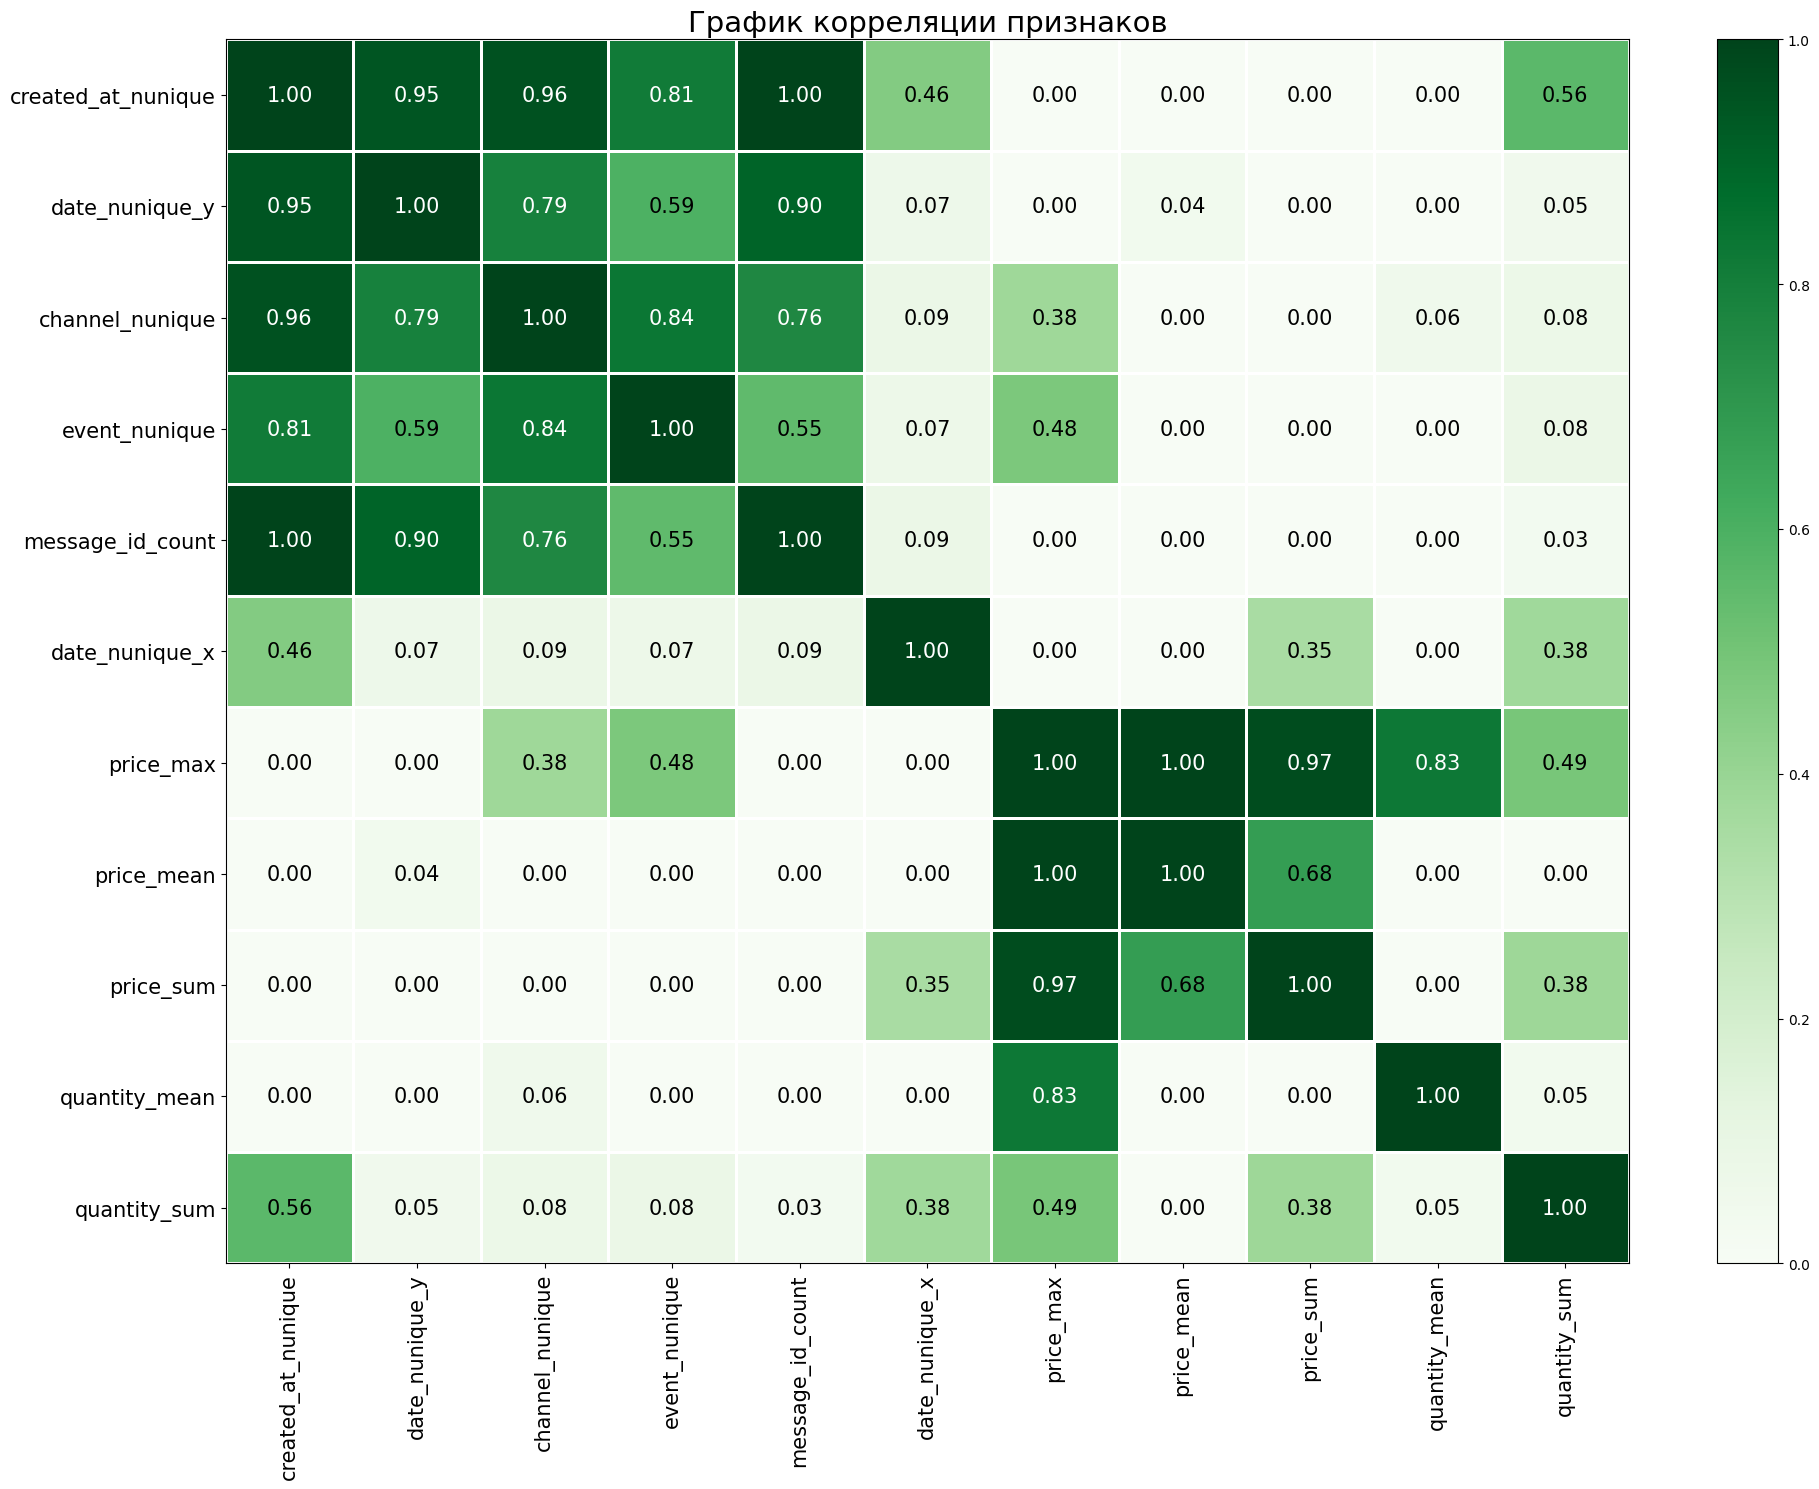

In [23]:
# отображаем матрицу
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title='График корреляции признаков',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

1. Очень высокая корреляция (0.97–1.00)
price_max, price_mean, price_sum
Эти признаки очень сильно коррелируют между собой. Это ожидаемо: если у пользователя высокая максимальная цена, скорее всего, и средняя, и сумма будут высокими.
created_at_nunique и message_id_count
Корреляция 0.98 — почти идентичные признаки (каждый уникальный created_at соответствует одному сообщению).
2. Высокая корреляция (0.7–0.9)
days_from_last_message_to_last_purchase с created_at_nunique, date_nunique_y, channel_nunique, event_nunique, message_id_count
Это говорит о том, что чем больше у пользователя сообщений/каналов/событий, тем больше разница между датой последней рекламы и последней покупки.
channel_nunique и event_nunique — 0.84. Пользователи, получающие сообщения по разным каналам, чаще имеют больше уникальных событий.
3. Средняя корреляция (0.4–0.7)
purchase_before_last_message с days_from_last_message_to_last_purchase — 0.84
Логично: если покупка была до последнего сообщения, разница между датами будет отрицательной или маленькой.
event_nunique с message_id_count — 0.55. Больше событий — больше сообщений.
4. Слабая или отсутствующая корреляция (<0.2)
quantity_sum, quantity_mean почти ни с чем не коррелируют
Это хорошо: эти признаки несут самостоятельную информацию.
price_max, price_mean, price_sum почти не коррелируют с количеством сообщений, каналов. 
Значит, денежные параметры и параметры коммуникаций — независимые признаки.


created_at_nunique, message_id_count, date_nunique_y — очень похожие признаки, можно оставить только один из них, чтобы избежать мультиколлинеарности.

price_max, price_mean, price_sum — тоже можно оставить только один или два, чтобы не дублировать информацию.

days_from_last_message_to_last_purchase и purchase_before_last_message — очень связаны, но оба могут быть полезны для модели.

In [24]:
del all_features['created_at_nunique'] 
del all_features['date_nunique_y'] 
del all_features['price_mean'] 
del all_features['price_max']

In [25]:
col_1 = ['quantity_sum', 'quantity_mean', 
        'price_sum', 'date_nunique_x',
        'message_id_count', 'event_nunique', 
        'channel_nunique'
        ]

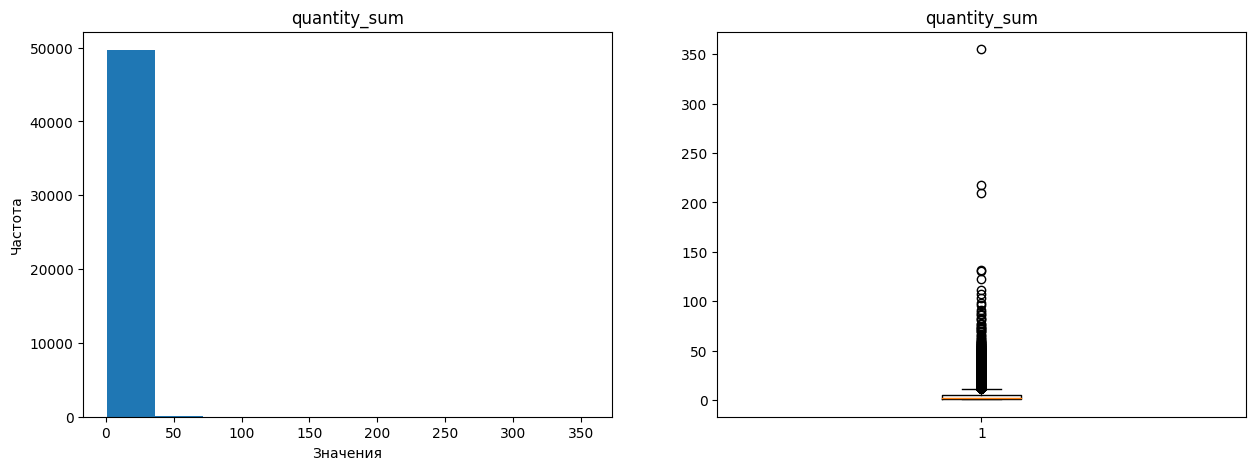

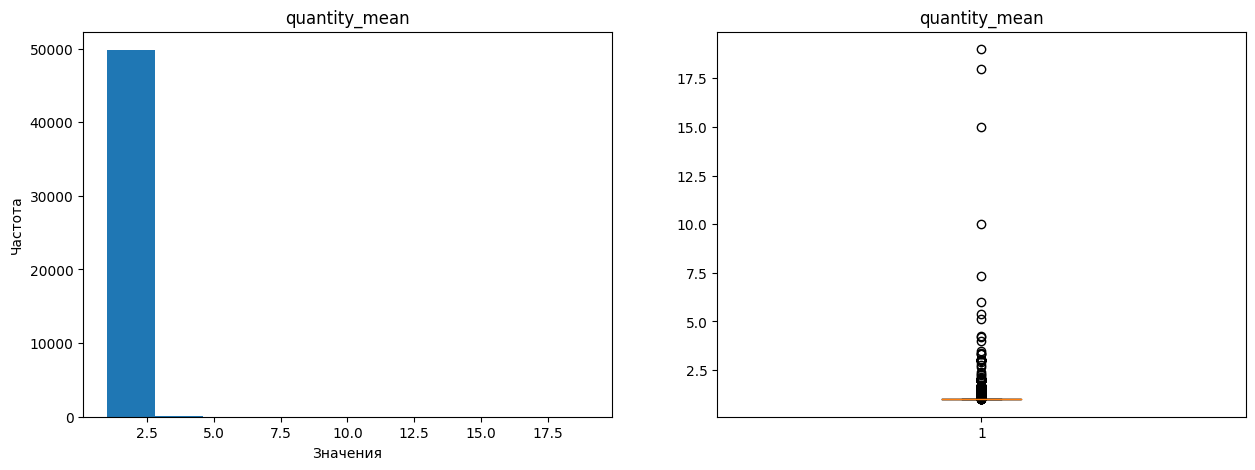

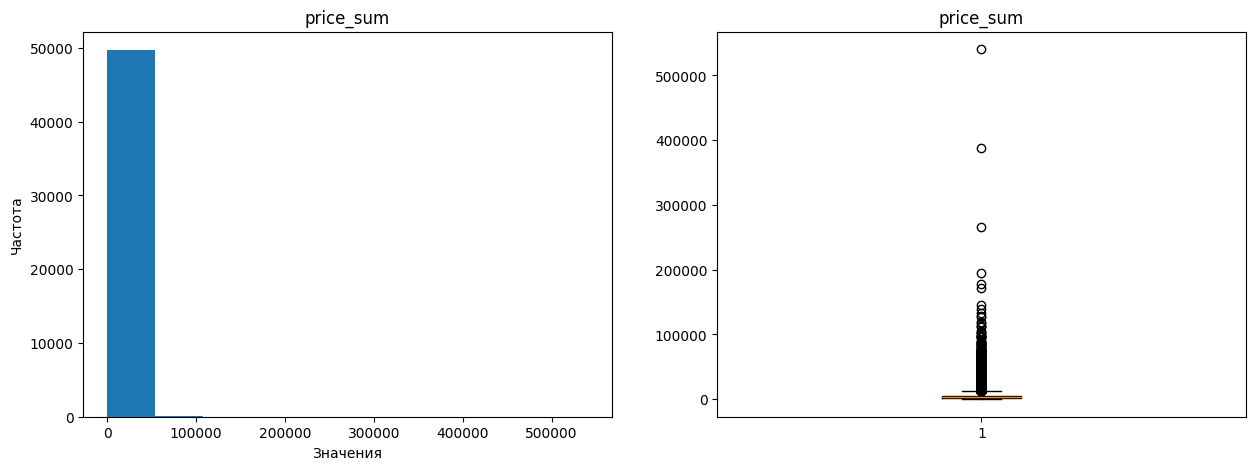

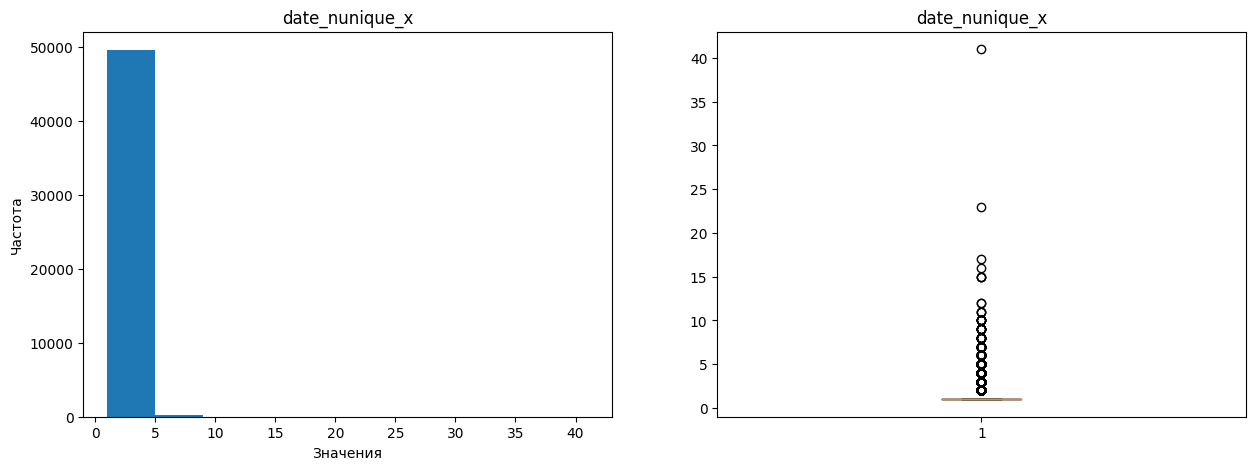

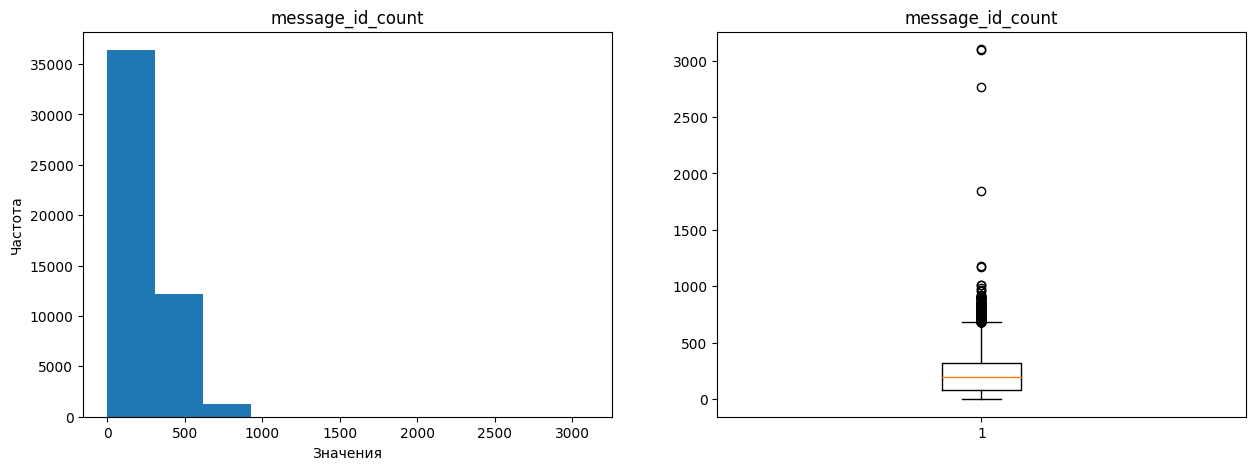

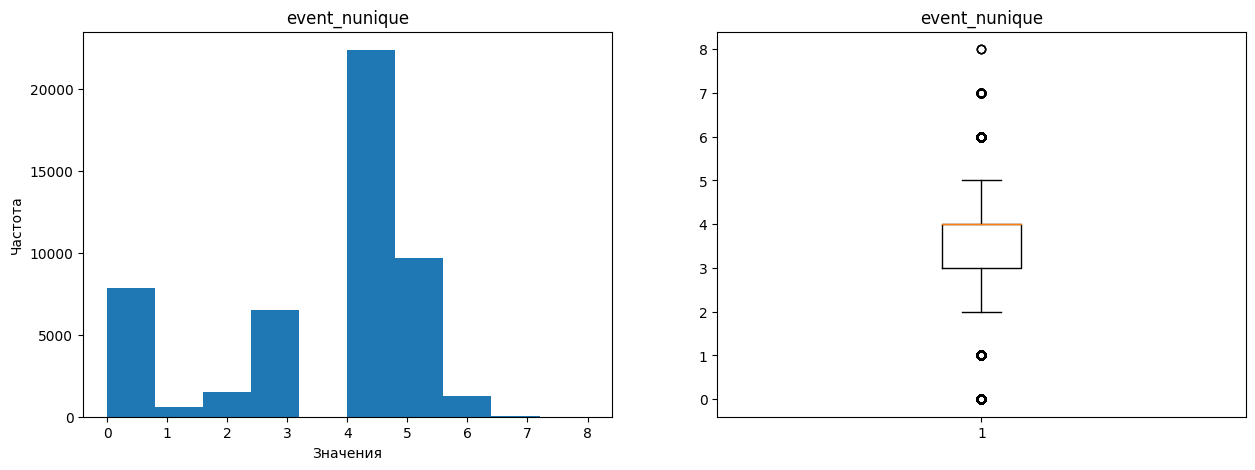

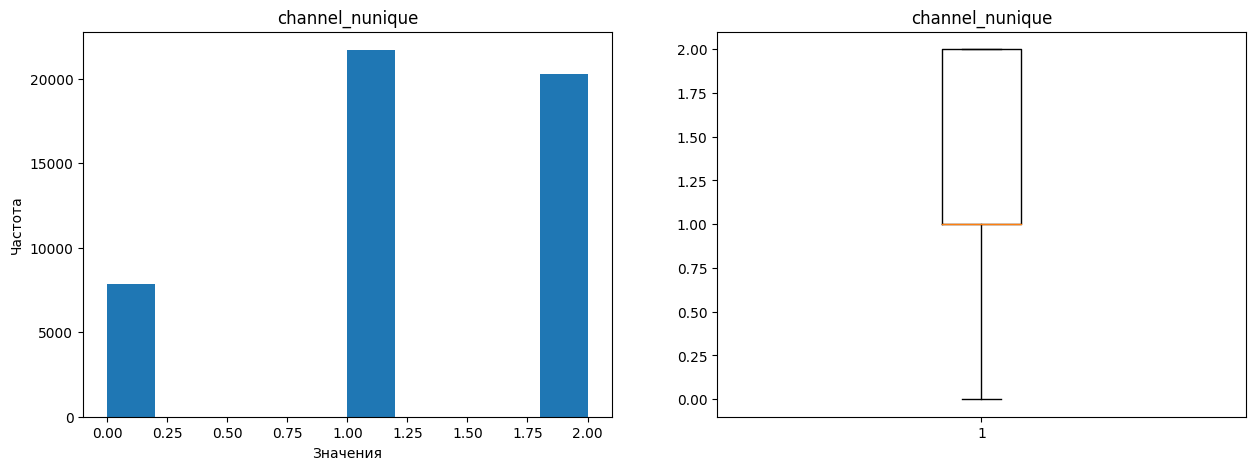

In [26]:
# строим гистограмму
todoplot(all_features)

В признаках есть выбросы, но они имеют место быть. Удалять их не будем.

## Построение модели

In [27]:
# Обозначаем тип параметров

num_columns = [
    'quantity_sum', 
    'quantity_mean', 
    'price_sum', 
    'date_nunique_x',
    'message_id_count', 
    'event_nunique', 
    'channel_nunique'
]

In [28]:
# Разделяем данные заново после преобразования
X = all_features.drop('client_id', axis=1)
y = target['target']

In [29]:
# разбиваем данные
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

In [30]:
print(X_train.shape)
print(X_test.shape)

(39879, 7)
(9970, 7)


In [33]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), num_columns)],
    remainder='drop'
)

In [34]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [('preprocessor', data_preprocessor),
     ('models', RandomForestClassifier())
    ]
)

In [35]:
#  подбираем параметры

param_grid = [
  {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__max_features': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    },
    
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    },

    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    },

    {
        'models': [SVC(random_state=RANDOM_STATE,kernel = 'rbf',probability=True)],
        'models__C': [0.1, 1, 10, 100, 1000],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    }
]

In [36]:
# используем метод RandomizedSearchCV для запуска обучения перебором
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [37]:
# обучение модели 
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['quantity_sum',
                                                                                'quantity_mean',
                                                                                'price_sum',
                                                                                'date_nunique_x',
                                                                                'message_id_count',
                                                                                'event_nunique',
                                                                                'channel_nunique'])])),
                                             ('models',
                                              RandomForestClassifier())]),
                   n_iter=20, n_jobs=-1,
                   param_distributions=[{'models': [DecisionTreeRegress...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 20),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'models__C': [0.1, 1, 10, 100, 1000],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]}],
                   random_state=42, scoring='roc_auc')

In [38]:
print('Лучшая модель и её параметры:\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)

Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['quantity_sum',
                                                   'quantity_mean', 'price_sum',
                                                   'date_nunique_x',
                                                   'message_id_count',
                                                   'event_nunique',
                                                   'channel_nunique'])])),
                ('models',
                 LogisticRegression(C=18, penalty='l1', random_state=42,
                                    solver='liblinear'))])
Метрика лучшей модели на кросс-валидации: 0.6745843872371946


In [39]:
y_pred_proba = randomized_search.predict_proba(X_test)[:, 1]

In [40]:
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_pred_proba)}')

Метрика ROC-AUC на тестовой выборке: 0.682938359149494


Лучая модель на определенных признаках получилась Логическая регресиия с параметрами С=18 и penalty='l1. C roc-auc равной 0.68. Рассмотрим веса признаков и определеим важнейший.

In [42]:
best_model = randomized_search.best_estimator_

In [43]:
final_model = best_model.named_steps['models']

In [44]:
importances = getattr(final_model, 'feature_importances_', None)
coefs = getattr(final_model, 'coef_', None)
coefs = coefs.ravel() 

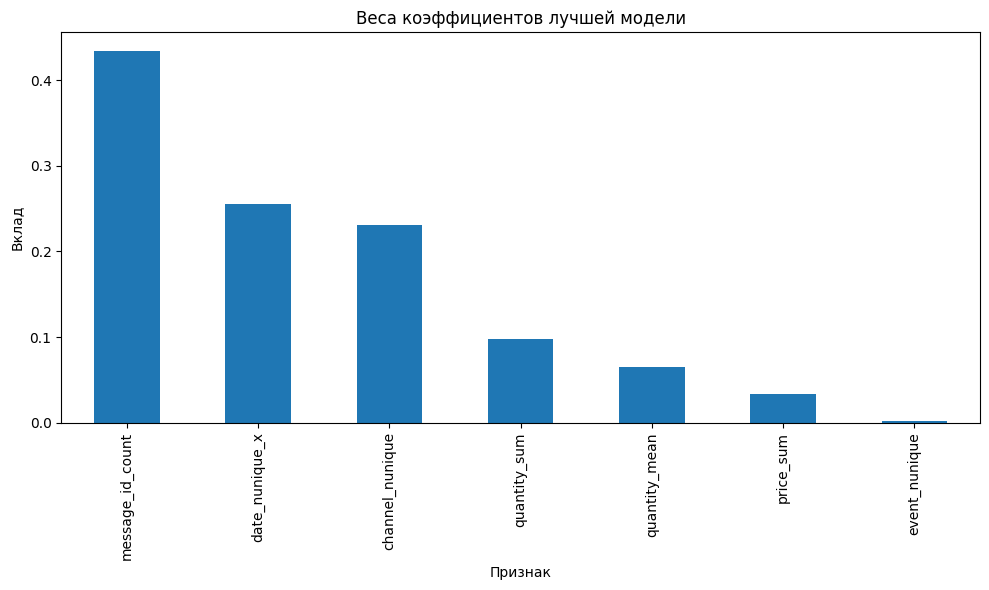

In [46]:

feat = pd.Series(np.abs(coefs), index=num_columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feat.plot(kind='bar')
plt.title('Веса коэффициентов лучшей модели')
plt.ylabel('Вклад')
plt.xlabel('Признак')
plt.tight_layout()
plt.show()

## Анализ важности признаков

<i>Наибольший вклад в предсказание модели вносят:</i>

message_id_count — количество сообщений, полученных пользователем. Это главный признак, влияющий на вероятность целевого события.

date_nunique_x — количество уникальных дат (скорее всего, дней активности или дней, когда были сообщения). Это тоже очень сильный индикатор активности пользователя.

channel_nunique — количество уникальных каналов коммуникации. Чем больше каналов, тем выше вероятность целевого действия.

quantity_sum — суммарное количество купленного товара.

quantity_mean — среднее количество за покупку.

price_sum — суммарная стоимость покупок.

event_nunique — число уникальных событий (например, open, click и т.д.), но его вклад минимален.

<i>Вывод:</i>

Модель считает, что наибольший вклад в вероятность целевого события вносят признаки, связанные с активностью пользователя (количество сообщений, дней, каналов). Финансовые параметры (сумма и среднее количество покупок) тоже важны, но чуть меньше. Поведенческие признаки (event_nunique) почти не влияют.

## Вывод

<i>О проекте</i><br>
Был проведен анализ данных популярного макетплейса. В результате встречи с командой было принято решение исключить некоторые таблицы их анализа.

<i>О моделе</i><br>
В ходе обучения была выбрана лучая модель логической регресии с параметрами С=18 и penalty='l1. А метрика roc-auc получилась равной 0.68.

<i>Анализ модели</i><br>
Модель опирается в первую очередь на признаки активности пользователя (количество сообщений, дней, каналов).<br>
Финансовые параметры тоже важны, но не ключевые.<br>

<i>Резюме</i><br>
Метрика ROC-AUC на тесте адекватная — значит, модель действительно хорошо различает пользователей, склонных к целевому действию, и не склонных.